<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [DCGAN1] - Deep Convolutional GAN with MNIST dataset
<!-- DESC --> Example of DCGAN with handwritten digit dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Generate handwritten digit with a GAN
 - Understanding the principle of a GAN 
 - Implementation with Keras 

Note : Deep Convolutional Generative Adversarial Network (DCGAN) is "Réseau Adversaire Génératif Convolutionnel Profond" in french..

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) is a must for Deep Learning.  
It consists of 60,000 small images of handwritten numbers for learning and 10,000 for testing.


## What we're going to do :

 - Retrieve data
 - Preparing the data



## Step 1 - Init python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import sys,os

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()
ooo.set_save_fig(save=True, figs_dir='./figs/01-DCGAN', figs_name='fig_', figs_id=0)


FIDLE 2020 - Practical Work Module
Version              : 0.5.0
Run time             : Friday 4 September 2020, 15:36:47
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf
Save figs            : True
Path figs            : ./figs/01-DCGAN


## Step 2 - Retrieve data
MNIST is one of the most famous historic dataset.  
Include in [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28)
y_train :  (60000,)
x_test  :  (10000, 28, 28)
y_test  :  (10000,)


## Step 3 - Preparing the data
### 3.1 - Load MNIST dataset (real data)

In [3]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


### 3.2 - Have a look

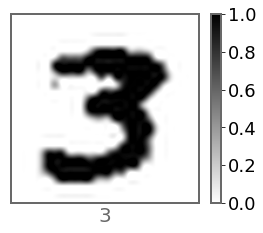

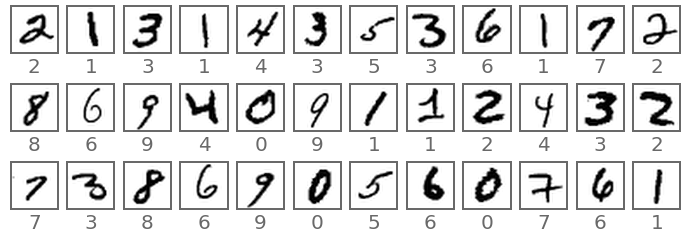

In [4]:
ooo.plot_images(x_train, y_train, [27],  x_size=5,y_size=5, colorbar=True)
ooo.plot_images(x_train, y_train, range(5,41), columns=12)

### 3.3 - Latent / Real / Fake data

In [5]:
def get_real_batch(x_dataset, batch_size):
    '''
    Get a real randomized set of data
    args:
        x_dataset : array of real images
        batch_size : size of desired batch set
    return:
        X : array of batch_size images
        y : array of batch_size classe 1 (class 1 mean real)
    '''
    # ---- Get random indices
    ii = np.random.randint(0, x_dataset.shape[0], batch_size)
    # ---- Retrieve images
    X = x_dataset[ii]
    # ---- Class labels (as real : 1)
    y = ones((batch_size, 1))
    return X, y


def get_latent_batch(latent_size, batch_size):
    '''
    Get a set of latent data
    args:
        latent_size : Size of the latent space
        batch_size : size of desired batch set
    return:
        x : array of batch_size latent vectors
    '''
    # ---- Get random points
    x = np.random.randn(latent_size * batch_size)
    # ---- Reshape it
    x = x.reshape(batch_size, latent_size)
    return x


def get_fake_batch(model_gen, latent_size, batch_size):
    '''
    Get a set of fake images
    args:
        model_g : Generator model
        lenten_size : Size of the latent space
        batch_size : Size of desired batch set
    return:
        X : array of batch_size fake images
        y : array of batch_size classe 1 (class 1 mean real)
    '''
    # ---- Get latent vectors
    x_latent = get_latent_batch(latent_size, batch_size)
    # ---- Get prediction
    X = model_gen.predict(x_latent)
    # ---- Class labels (as real : 1)
    y = zeros((batch_size, 1))
    return X, y

## Step 4 - Preparing models

In [6]:
def get_discriminator_model(lx,ly,lz):
    
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(lx,ly,lz)) )
    model.add( keras.layers.LeakyReLU(alpha=0.2) )
    model.add( keras.layers.Dropout(0.4))
    
    model.add( keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same') )
    model.add( keras.layers.LeakyReLU(alpha=0.2) )
    model.add( keras.layers.Dropout(0.4) )
    
    model.add( keras.layers.Flatten() )
    model.add( keras.layers.Dense(1, activation='sigmoid') )
    
    model.compile(loss      = 'binary_crossentropy', 
                  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5), 
                  metrics   = ['accuracy'])
    return model


def get_generator_model(latent_size):
    
    model = keras.models.Sequential()
    
    # ---- latent vector => 7x7 images, 128 versions
    #
    model.add( keras.layers.Dense(7*7*128, input_dim=latent_size) )
    model.add( keras.layers.LeakyReLU(alpha=0.2) )
    model.add( keras.layers.Reshape((7, 7, 128)) )

    # ---- 7x7 => 14x14, 128 versions
    #
    model.add( keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same') )
    model.add( keras.layers.LeakyReLU(alpha=0.2) )
    
    # ---- 14x14 => 28x28, 128 versions
    #
    model.add( keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same') )
    model.add( keras.layers.LeakyReLU(alpha=0.2) )
    
    # ---- 28x28, 128 versions => 28x28 [0,1]
    #
    model.add( keras.layers.Conv2D(1, (7,7), padding='same', activation='sigmoid') )
    return model


def get_gan_model(model_gen, model_disc):
    
    # ---- This model will be use to only train the generator
    #      because all generated images are fake
    #
    model_disc.trainable = False
    
    # ---- Connect Generator and Discriminator models
    #
    model = keras.models.Sequential()
    model.add(model_gen)
    model.add(model_disc)
    
    # ---- Compile model
    #
    model.compile(loss      = 'binary_crossentropy', 
                  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5), 
                  metrics   = ['accuracy'])

    return model

Show them

<br>**Generator :**

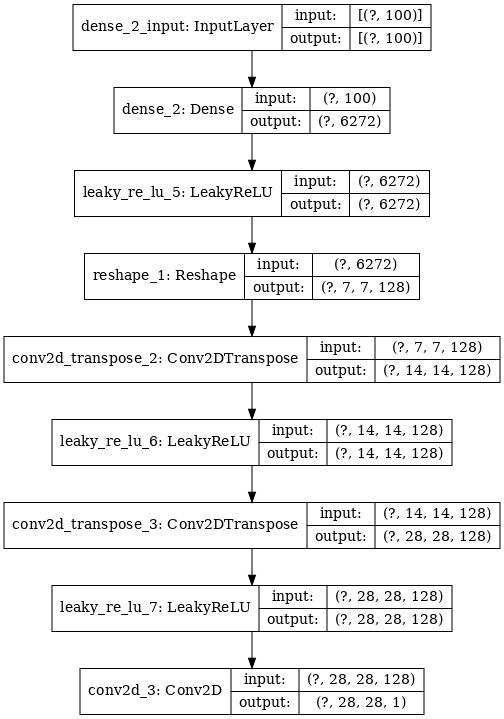

<br>**Discriminator :**

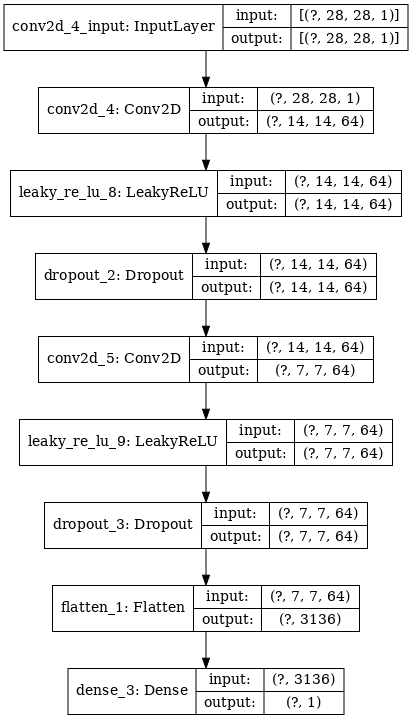

<br>**Gan :**

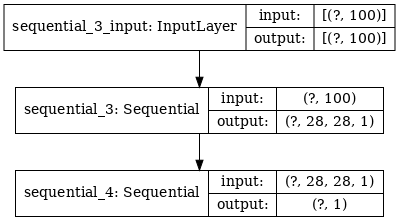

In [8]:
model_gen  = get_generator_model(100)
model_disc = get_discriminator_model(28,28,1)
model_gan  = get_gan_model(model_gen, model_disc)

ooo.subtitle('Generator :')
# model_gen.summary()
img_gen = keras.utils.plot_model( model_gen, to_file='./figs/01-DCGAN/generator.png',     show_shapes=True, show_layer_names=True, dpi=72)
display(img_gen)

ooo.subtitle('Discriminator :')
# model_disc.summary()
img_disc = keras.utils.plot_model( model_disc, to_file='./figs/01-DCGAN/discriminator.png', show_shapes=True, show_layer_names=True, dpi=72)
display(img_disc)

ooo.subtitle('Gan :')
# model_gan.summary()
img_gan = keras.utils.plot_model( model_gan, to_file='./figs/01-DCGAN/gan.png',     show_shapes=True, show_layer_names=True, dpi=72)
display(img_gan)


## Step 5 - Training 

In [1]:
def train_gan(model_gan, latent_size, batch_size=256, n_epochs=100):
    '''
    Entraine le génerateur à partir des erreurs du discriminateur.
    Pour cela, on entraine le modèle gan (generateur->discriminateur) dont le discriminateur est figé.
    '''
    
    # ---- Epoch after epoch...
    #
    for i in range(n_epochs):
        # ---- Get train data
        x_gan = get_latent_batch(latent_size, batch_size)
        y_gan = ones((batch_size, 1))
        # ---- Train and update the generator via the discriminator's errors
        model_gan.train_on_batch(x_gan, y_gan)
    
    
def train(model_gen, model_disc, model_gan, dataset, latent_size, batch_size=256, n_epochs=100):
    
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch      = int(batch_size / 2)
    
    # ---- Epoch after epoch...
    #
    for i in range(n_epochs):
        
        # ---- Batch after batch
        #
        for j in range(batch_per_epoch):

            # ---- Train discriminator
            #
            # Prepare real and fake images and concatenate them
            #
            x_real, y_real = get_real_batch(dataset, half_batch)
            x_fake, y_fake = get_fake_batch(model_gen, latent_size, half_batch)
            x, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
            #
            # Train discriminator
            #
            loss_disc, _ = model_disc.train_on_batch(x, y)
            
            # ---- Train generator
            #
            # Prepare latent batch for the generator (gan model)
            #
            x = get_latent_batch(latent_size, batch_size)
            y = ones((n_batch, 1))
            #
            # Train it via the discriminator's errors
            #
            loss_gen = model_gan.train_on_batch(x, y)
            
            # ---- Show batch loss
            #
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, loss_disc, loss_gen))

In [ ]:
# next : p117